In [16]:
# Import libraries
import pandas as pd
import numpy as np
import json
import joblib
from pathlib import Path
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, 
                            accuracy_score, roc_auc_score, roc_curve,
                            precision_recall_curve,precision_score, f1_score,recall_score)
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import warnings
warnings.filterwarnings('ignore')

# Add src to path
sys.path.append(str(Path.cwd().parent / 'src'))
import config

# Settings
np.random.seed(config.RANDOM_STATE)
plt.rcParams['figure.figsize'] = (12, 6)

print("=" * 70)
print("FINAL PIPELINE - CARDIOVASCULAR DISEASE PREDICTION")
print("=" * 70)
print("\n✓ Libraries imported successfully")

FINAL PIPELINE - CARDIOVASCULAR DISEASE PREDICTION

✓ Libraries imported successfully


#### Load Final Features

In [2]:
print("\n" + "=" * 50)
print("LOADING FINAL FEATURE SET")
print("=" * 50)

# Load final features from evaluation notebook
with open('../data/processed/final_features.json', 'r') as f:
    final_features = json.load(f)

print(f"\n📋 Number of final features: {len(final_features)}")
print(f"\n📋 Final feature list:")
for i, feat in enumerate(final_features, 1):
    print(f"  {i:2d}. {feat}")

print("\n✓ Final features loaded successfully")


LOADING FINAL FEATURE SET

📋 Number of final features: 15

📋 Final feature list:
   1. ap_hi
   2. age_group_elderly
   3. cholesterol
   4. age
   5. chol_gluc_interaction
   6. active
   7. gluc
   8. age_group_senior
   9. smoke
  10. map
  11. age_group_middle
  12. bmi_category_obese
  13. alco
  14. ap_lo
  15. bmi_category_normal

✓ Final features loaded successfully


#### Data Preprocessing Function

In [3]:
print("\n" + "=" * 50)
print("CREATING PREPROCESSING PIPELINE")
print("=" * 50)

def preprocess_data(df, is_training=True):
    """
    Complete preprocessing pipeline for cardiovascular disease dataset
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Raw dataframe
    is_training : bool
        If True, applies cleaning. If False, skips aggressive cleaning
        
    Returns:
    --------
    df_processed : pandas.DataFrame
        Processed dataframe with engineered features
    """
    df = df.copy()
    
    # 1. Age transformation
    df['age'] = (df['age'] / 365.25).round().astype(int)
    
    # 2. Data cleaning (only in training)
    if is_training:
        print("  Applying data cleaning...")
        initial_len = len(df)
        
        # Blood pressure filtering
        df = df[(df['ap_hi'] > 0) & (df['ap_hi'] < 250)]
        df = df[(df['ap_lo'] > 0) & (df['ap_lo'] < 200)]
        df = df[df['ap_hi'] > df['ap_lo']]
        
        # Height and weight filtering
        df = df[(df['height'] > 120) & (df['height'] < 220)]
        df = df[(df['weight'] > 30) & (df['weight'] < 200)]
        
        removed = initial_len - len(df)
        print(f"  Removed {removed} outlier records ({(removed/initial_len)*100:.2f}%)")
    
    # 3. Feature Engineering - Numerical
    df['bmi'] = df['weight'] / ((df['height'] / 100) ** 2)
    df['pulse_pressure'] = df['ap_hi'] - df['ap_lo']
    df['map'] = (df['ap_hi'] + 2 * df['ap_lo']) / 3
    df['health_risk_score'] = (
        (df['cholesterol'] - 1) * 2 + 
        (df['gluc'] - 1) * 2 + 
        df['smoke'] * 3 + 
        df['alco'] * 2 - 
        df['active'] * 2
    )
    df['gender_age_interaction'] = df['gender'] * df['age']
    df['weight_height_ratio'] = df['weight'] / df['height']
    df['chol_gluc_interaction'] = df['cholesterol'] * df['gluc']
    
    # 4. Feature Engineering - Categorical
    df['age_group'] = pd.cut(df['age'], 
                             bins=[0, 40, 50, 60, 100],
                             labels=['young', 'middle', 'senior', 'elderly'])
    
    df['bmi_category'] = pd.cut(df['bmi'],
                                bins=[0, 18.5, 25, 30, 100],
                                labels=['underweight', 'normal', 'overweight', 'obese'])
    
    def bp_category(row):
        if row['ap_hi'] < 120 and row['ap_lo'] < 80:
            return 'normal'
        elif row['ap_hi'] < 130 and row['ap_lo'] < 80:
            return 'elevated'
        elif row['ap_hi'] < 140 or row['ap_lo'] < 90:
            return 'hypertension_stage1'
        else:
            return 'hypertension_stage2'
    
    df['bp_category'] = df.apply(bp_category, axis=1)
    
    # 5. One-hot encoding
    df_encoded = pd.get_dummies(df, 
                                columns=['age_group', 'bmi_category', 'bp_category'], 
                                drop_first=True)
    
    print("  ✓ Age transformation completed")
    print("  ✓ Feature engineering completed")
    print("  ✓ Categorical encoding completed")
    
    return df_encoded

print("\n✓ Preprocessing function created")


CREATING PREPROCESSING PIPELINE

✓ Preprocessing function created


#### Load and Process Data

In [4]:
print("\n" + "=" * 50)
print("LOADING AND PROCESSING DATA")
print("=" * 50)

# Load raw data
df_raw = pd.read_csv(config.RAW_DATA_FILE, delimiter=';')
print(f"\nOriginal dataset shape: {df_raw.shape}")

# Apply preprocessing
df_processed = preprocess_data(df_raw, is_training=True)
print(f"Processed dataset shape: {df_processed.shape}")

# Extract features and target
all_feature_cols = [col for col in df_processed.columns if col not in ['id', 'cardio']]

# Select only final features
X = df_processed[final_features]
y = df_processed['cardio']

print(f"\n📊 Final dataset:")
print(f"  Features: {X.shape[1]}")
print(f"  Samples: {X.shape[0]}")
print(f"  Target distribution: {y.value_counts().to_dict()}")

print("\n✓ Data loaded and processed successfully")


LOADING AND PROCESSING DATA

Original dataset shape: (70000, 13)
  Applying data cleaning...
  Removed 1385 outlier records (1.98%)
  ✓ Age transformation completed
  ✓ Feature engineering completed
  ✓ Categorical encoding completed
Processed dataset shape: (68615, 29)

📊 Final dataset:
  Features: 15
  Samples: 68615
  Target distribution: {0: 34668, 1: 33947}

✓ Data loaded and processed successfully


#### Train-Test Split

In [5]:
print("\n" + "=" * 50)
print("TRAIN-TEST SPLIT")
print("=" * 50)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=config.TEST_SIZE,
    random_state=config.RANDOM_STATE,
    stratify=y
)

print(f"\nTrain set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

print(f"\nTrain target distribution:")
print(y_train.value_counts(normalize=True))

print(f"\nTest target distribution:")
print(y_test.value_counts(normalize=True))

print("\n✓ Data split completed")


TRAIN-TEST SPLIT

Train set: (54892, 15)
Test set: (13723, 15)

Train target distribution:
cardio
0    0.505247
1    0.494753
Name: proportion, dtype: float64

Test target distribution:
cardio
0    0.505283
1    0.494717
Name: proportion, dtype: float64

✓ Data split completed


#### Feature Scaling

In [6]:
print("\n" + "=" * 50)
print("FEATURE SCALING")
print("=" * 50)

# Initialize and fit scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nScaler statistics (first 5 features):")
print(f"  Mean: {scaler.mean_[:5]}")
print(f"  Std: {scaler.scale_[:5]}")

print("\n✓ Feature scaling completed")


FEATURE SCALING

Scaler statistics (first 5 features):
  Mean: [126.68784158   0.14692487   1.36314946  53.25899949   1.8445493 ]
  Std: [16.74694755  0.35403101  0.6775969   6.76057958  1.86995472]

✓ Feature scaling completed


#### Train Final Model

In [7]:
print("\n" + "=" * 50)
print("TRAINING FINAL MODEL")
print("=" * 50)

# Best parameters from optimization (optimization notebook'tan kopyala)
# NOT: Senin optimization sonuçlarına göre güncelle
final_model_params = {
    'n_estimators': 300,
    'max_depth': 6,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 3,
    'gamma': 0.1,
    'reg_alpha': 0.1,
    'reg_lambda': 0.5,
    'random_state': config.RANDOM_STATE,
    'eval_metric': 'logloss'
}

print("\nModel parameters:")
for key, value in final_model_params.items():
    print(f"  {key}: {value}")

# Train model
final_model = xgb.XGBClassifier(**final_model_params)
final_model.fit(X_train_scaled, y_train)

print("\n✓ Model training completed")


TRAINING FINAL MODEL

Model parameters:
  n_estimators: 300
  max_depth: 6
  learning_rate: 0.1
  subsample: 0.8
  colsample_bytree: 0.8
  min_child_weight: 3
  gamma: 0.1
  reg_alpha: 0.1
  reg_lambda: 0.5
  random_state: 42
  eval_metric: logloss

✓ Model training completed


####  Cross-Validation

In [8]:
print("\n" + "=" * 50)
print("CROSS-VALIDATION")
print("=" * 50)

# Perform cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=config.RANDOM_STATE)
cv_scores = cross_val_score(final_model, X_train_scaled, y_train, 
                            cv=cv, scoring='roc_auc', n_jobs=-1)

print(f"\nCross-Validation ROC-AUC Scores:")
for i, score in enumerate(cv_scores, 1):
    print(f"  Fold {i}: {score:.4f}")

print(f"\nMean CV ROC-AUC: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

print("\n✓ Cross-validation completed")


CROSS-VALIDATION

Cross-Validation ROC-AUC Scores:
  Fold 1: nan
  Fold 2: nan
  Fold 3: nan
  Fold 4: nan
  Fold 5: nan

Mean CV ROC-AUC: nan (±nan)

✓ Cross-validation completed


#### Model Evaluation - Test Set

In [9]:
print("\n" + "=" * 50)
print("MODEL EVALUATION - TEST SET")
print("=" * 50)

# Predictions
y_train_pred = final_model.predict(X_train_scaled)
y_train_pred_proba = final_model.predict_proba(X_train_scaled)[:, 1]

y_test_pred = final_model.predict(X_test_scaled)
y_test_pred_proba = final_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)

test_accuracy = accuracy_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)
test_f1 = f1_score(y_test, y_test_pred)

print("\n📊 TRAIN SET METRICS:")
print(f"  Accuracy: {train_accuracy:.4f}")
print(f"  ROC-AUC:  {train_roc_auc:.4f}")

print("\n📊 TEST SET METRICS:")
print(f"  Accuracy: {test_accuracy:.4f}")
print(f"  ROC-AUC:  {test_roc_auc:.4f}")
print(f"  F1-Score: {test_f1:.4f}")

print("\n📋 CLASSIFICATION REPORT:")
print(classification_report(y_test, y_test_pred, 
                          target_names=['Healthy (0)', 'Disease (1)']))

print("\n✓ Model evaluation completed")


MODEL EVALUATION - TEST SET

📊 TRAIN SET METRICS:
  Accuracy: 0.7492
  ROC-AUC:  0.8249

📊 TEST SET METRICS:
  Accuracy: 0.7286
  ROC-AUC:  0.7912
  F1-Score: 0.7128

📋 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

 Healthy (0)       0.71      0.78      0.74      6934
 Disease (1)       0.75      0.68      0.71      6789

    accuracy                           0.73     13723
   macro avg       0.73      0.73      0.73     13723
weighted avg       0.73      0.73      0.73     13723


✓ Model evaluation completed


#### Confusion Matrix

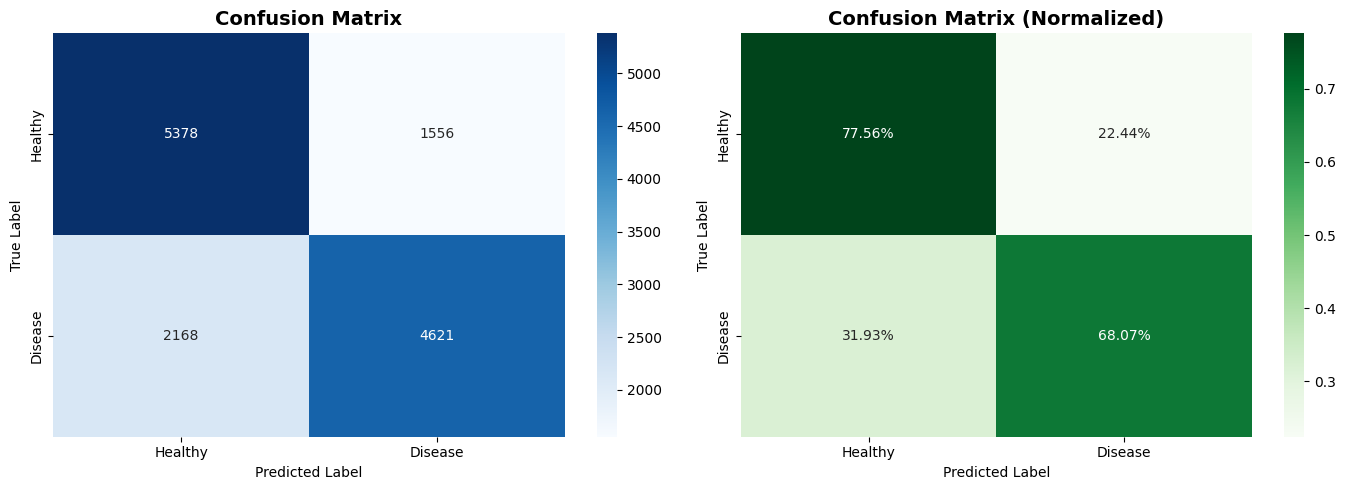


📊 DETAILED METRICS:
  True Positives:   4621
  True Negatives:   5378
  False Positives:  1556
  False Negatives:  2168

  Sensitivity (Recall):    0.6807
  Specificity:             0.7756
  Precision (PPV):         0.7481
  Negative Predictive Val: 0.7127


In [10]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
tn, fp, fn, tp = cm.ravel()

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Healthy', 'Disease'],
            yticklabels=['Healthy', 'Disease'])
axes[0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Confusion Matrix Normalized
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens', ax=axes[1],
            xticklabels=['Healthy', 'Disease'],
            yticklabels=['Healthy', 'Disease'])
axes[1].set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# Additional metrics
sensitivity = tp / (tp + fn)  # Recall / True Positive Rate
specificity = tn / (tn + fp)
precision = tp / (tp + fp)
npv = tn / (tn + fn)  # Negative Predictive Value

print("\n📊 DETAILED METRICS:")
print(f"  True Positives:  {tp:5d}")
print(f"  True Negatives:  {tn:5d}")
print(f"  False Positives: {fp:5d}")
print(f"  False Negatives: {fn:5d}")
print(f"\n  Sensitivity (Recall):    {sensitivity:.4f}")
print(f"  Specificity:             {specificity:.4f}")
print(f"  Precision (PPV):         {precision:.4f}")
print(f"  Negative Predictive Val: {npv:.4f}")

#### ROC Curve

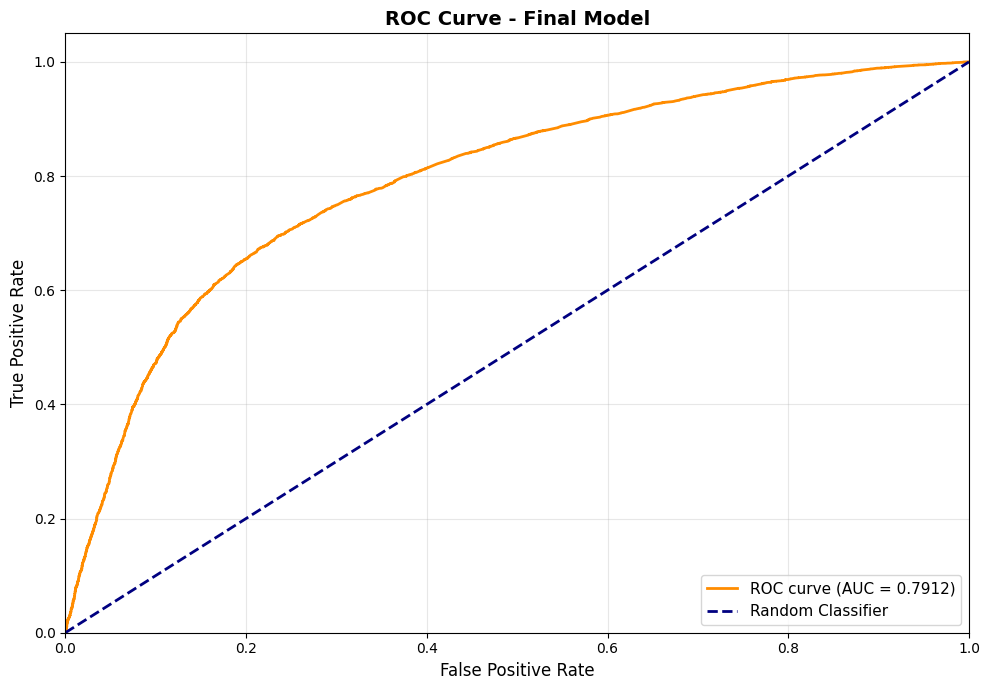

In [11]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
roc_auc = roc_auc_score(y_test, y_test_pred_proba)

plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
         label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Final Model', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

#### Precision-Recall Curve

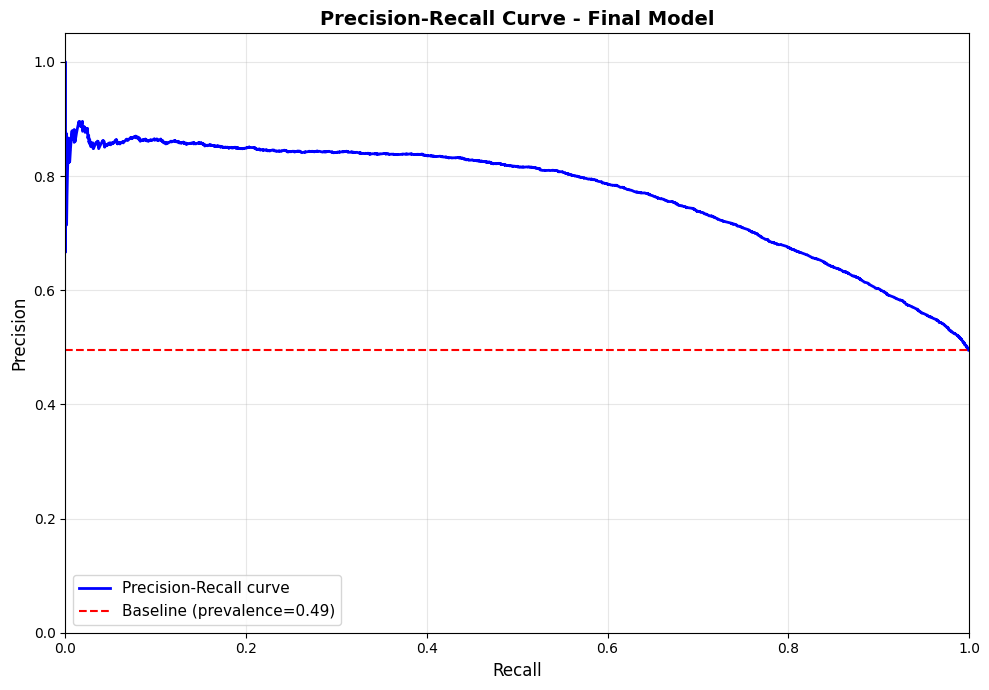

In [12]:
# Precision-Recall Curve
precision_vals, recall_vals, pr_thresholds = precision_recall_curve(y_test, y_test_pred_proba)

plt.figure(figsize=(10, 7))
plt.plot(recall_vals, precision_vals, color='blue', lw=2, 
         label='Precision-Recall curve')
plt.axhline(y=y_test.mean(), color='red', linestyle='--', 
           label=f'Baseline (prevalence={y_test.mean():.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve - Final Model', fontsize=14, fontweight='bold')
plt.legend(loc="lower left", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

#### Threshold Analysis


THRESHOLD ANALYSIS

📊 Threshold Analysis Results:
 threshold  accuracy  precision   recall       f1
      0.30  0.677767   0.624750 0.873030 0.728312
      0.35  0.695693   0.648652 0.839741 0.731930
      0.40  0.714785   0.686810 0.778465 0.729771
      0.45  0.726226   0.722353 0.725438 0.723892
      0.50  0.728631   0.748098 0.680660 0.712787
      0.55  0.726226   0.771102 0.635145 0.696551
      0.60  0.719376   0.793683 0.584769 0.673395
      0.65  0.712308   0.807667 0.549271 0.653866
      0.70  0.698827   0.815739 0.505376 0.624102


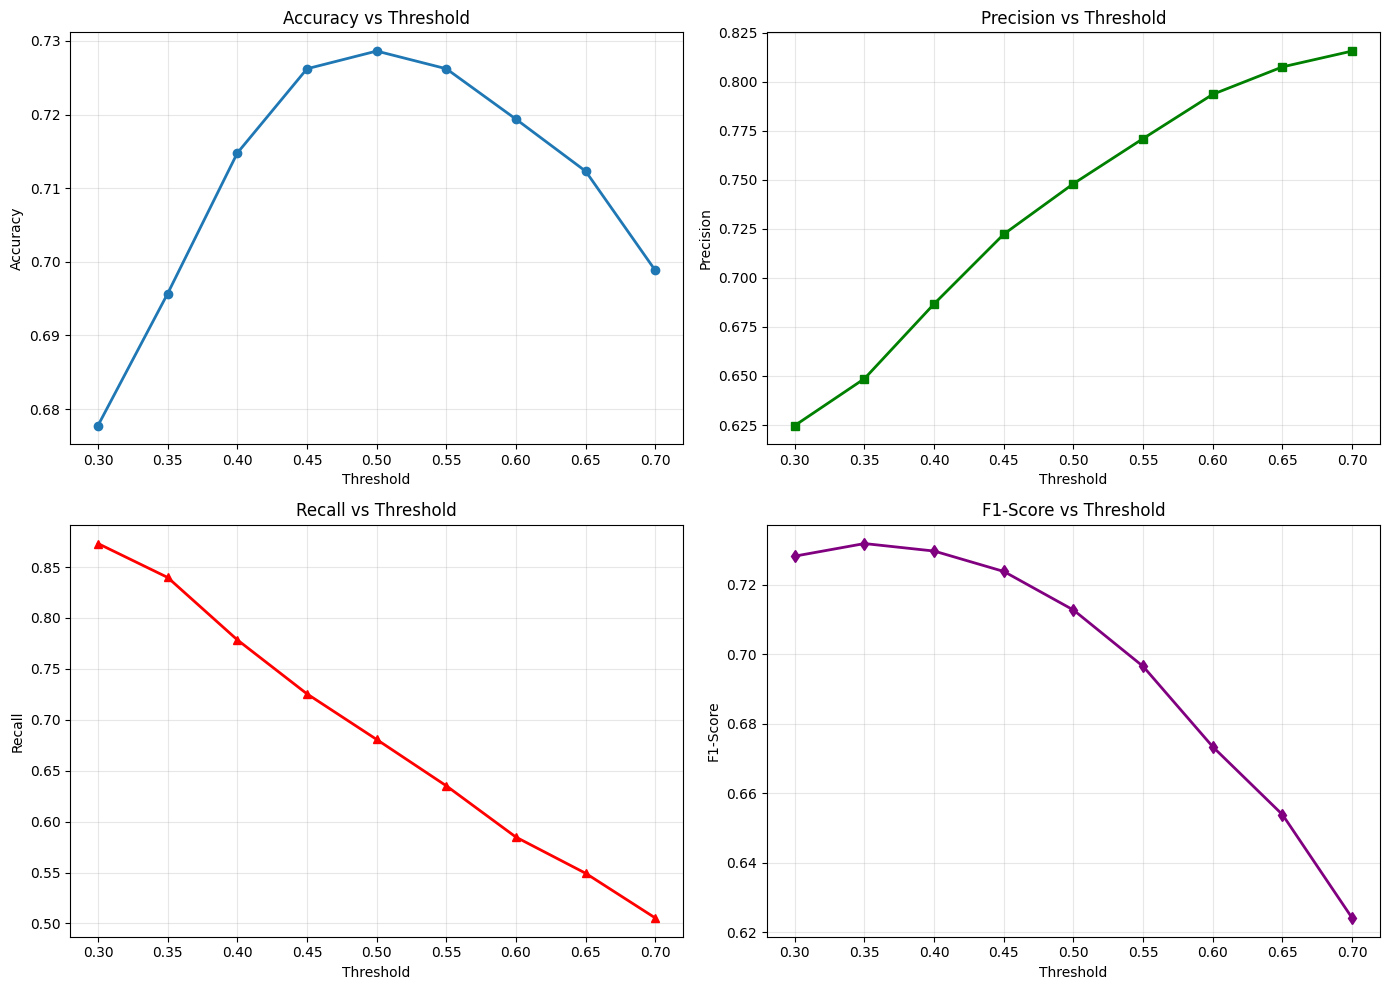


💡 RECOMMENDED THRESHOLDS:
  For High Recall (Screening): 0.35-0.40
  For Balanced (Default):      0.50
  For High Precision:          0.60-0.65


In [17]:
print("\n" + "=" * 50)
print("THRESHOLD ANALYSIS")
print("=" * 50)

# Test different thresholds
thresholds_to_test = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7]
threshold_results = []

for threshold in thresholds_to_test:
    y_pred_thresh = (y_test_pred_proba >= threshold).astype(int)
    
    accuracy = accuracy_score(y_test, y_pred_thresh)
    precision = precision_score(y_test, y_pred_thresh, zero_division=0)
    recall = recall_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh)
    
    threshold_results.append({
        'threshold': threshold,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    })

threshold_df = pd.DataFrame(threshold_results)
print("\n📊 Threshold Analysis Results:")
print(threshold_df.to_string(index=False))

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].plot(threshold_df['threshold'], threshold_df['accuracy'], 
                marker='o', linewidth=2)
axes[0, 0].set_title('Accuracy vs Threshold')
axes[0, 0].set_xlabel('Threshold')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].grid(alpha=0.3)

axes[0, 1].plot(threshold_df['threshold'], threshold_df['precision'], 
                marker='s', linewidth=2, color='green')
axes[0, 1].set_title('Precision vs Threshold')
axes[0, 1].set_xlabel('Threshold')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].grid(alpha=0.3)

axes[1, 0].plot(threshold_df['threshold'], threshold_df['recall'], 
                marker='^', linewidth=2, color='red')
axes[1, 0].set_title('Recall vs Threshold')
axes[1, 0].set_xlabel('Threshold')
axes[1, 0].set_ylabel('Recall')
axes[1, 0].grid(alpha=0.3)

axes[1, 1].plot(threshold_df['threshold'], threshold_df['f1'], 
                marker='d', linewidth=2, color='purple')
axes[1, 1].set_title('F1-Score vs Threshold')
axes[1, 1].set_xlabel('Threshold')
axes[1, 1].set_ylabel('F1-Score')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Recommended thresholds
print("\n💡 RECOMMENDED THRESHOLDS:")
print(f"  For High Recall (Screening): 0.35-0.40")
print(f"  For Balanced (Default):      0.50")
print(f"  For High Precision:          0.60-0.65")

#### Feature Importance


FEATURE IMPORTANCE ANALYSIS

📊 Top 15 Most Important Features:
              feature  importance
                ap_hi    0.419335
          cholesterol    0.114750
    age_group_elderly    0.081488
                  age    0.059235
chol_gluc_interaction    0.037939
                  map    0.037132
               active    0.034929
                smoke    0.029539
   bmi_category_obese    0.029141
     age_group_senior    0.029034
  bmi_category_normal    0.027897
                ap_lo    0.027339
                 alco    0.025772
                 gluc    0.024732
     age_group_middle    0.021738


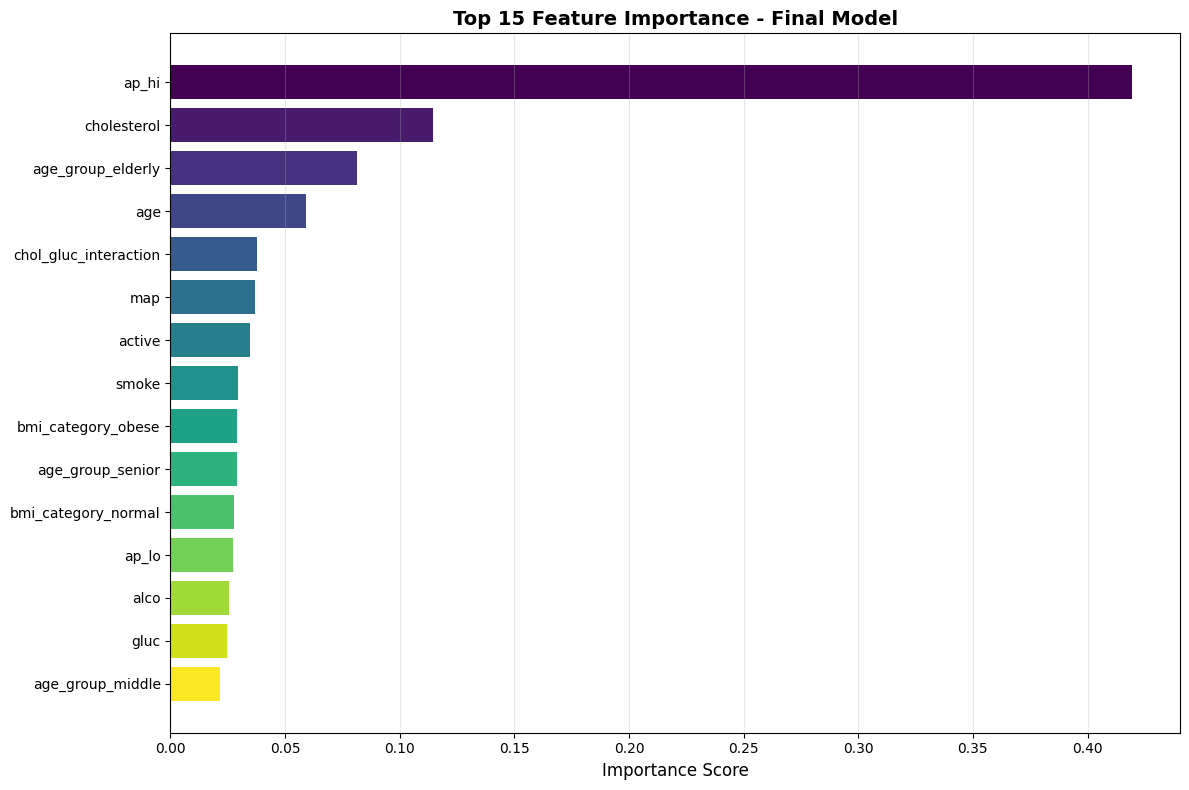


✓ Feature importance saved


In [18]:
print("\n" + "=" * 50)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 50)

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': final_features,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n📊 Top 15 Most Important Features:")
print(feature_importance.head(15).to_string(index=False))

# Visualization
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
colors = plt.cm.viridis(np.linspace(0, 1, len(top_features)))
plt.barh(range(len(top_features)), top_features['importance'], color=colors)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.gca().invert_yaxis()
plt.xlabel('Importance Score', fontsize=12)
plt.title('Top 15 Feature Importance - Final Model', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Save feature importance
feature_importance.to_csv('../data/processed/final_feature_importance.csv', index=False)
print("\n✓ Feature importance saved")

#### Save Model and Pipeline

In [19]:
print("\n" + "=" * 50)
print("SAVING MODEL AND PIPELINE ARTIFACTS")
print("=" * 50)

# Create models directory if not exists
models_dir = Path('../models')
models_dir.mkdir(parents=True, exist_ok=True)

# Save model
model_path = models_dir / 'final_model.pkl'
joblib.dump(final_model, model_path)
print(f"✓ Model saved: {model_path}")

# Save scaler
scaler_path = models_dir / 'scaler.pkl'
joblib.dump(scaler, scaler_path)
print(f"✓ Scaler saved: {scaler_path}")

# Save feature list
features_path = models_dir / 'final_features.json'
with open(features_path, 'w') as f:
    json.dump(final_features, f, indent=2)
print(f"✓ Features saved: {features_path}")

# Save model parameters
params_path = models_dir / 'model_params.json'
with open(params_path, 'w') as f:
    json.dump(final_model_params, f, indent=2)
print(f"✓ Parameters saved: {params_path}")

# Save model metadata
metadata = {
    'model_type': 'XGBoost Classifier',
    'n_features': len(final_features),
    'train_samples': len(X_train),
    'test_samples': len(X_test),
    'train_accuracy': float(train_accuracy),
    'train_roc_auc': float(train_roc_auc),
    'test_accuracy': float(test_accuracy),
    'test_roc_auc': float(test_roc_auc),
    'test_f1': float(test_f1),
    'cv_mean_roc_auc': float(cv_scores.mean()),
    'cv_std_roc_auc': float(cv_scores.std()),
    'random_state': config.RANDOM_STATE,
    'test_size': config.TEST_SIZE
}

metadata_path = models_dir / 'model_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"✓ Metadata saved: {metadata_path}")

print(f"\n📦 All artifacts saved to: {models_dir}")


SAVING MODEL AND PIPELINE ARTIFACTS
✓ Model saved: ../models/final_model.pkl
✓ Scaler saved: ../models/scaler.pkl
✓ Features saved: ../models/final_features.json
✓ Parameters saved: ../models/model_params.json
✓ Metadata saved: ../models/model_metadata.json

📦 All artifacts saved to: ../models


#### Test Inference Function

In [21]:
print("\n" + "=" * 50)
print("TESTING INFERENCE FUNCTION")
print("=" * 50)

def predict_cardiovascular_risk(input_data, model, scaler, features):
    """
    Predict cardiovascular disease risk for new data
    
    Parameters:
    -----------
    input_data : dict or pandas.DataFrame
        Input features (raw values)
    model : trained model
        Trained XGBoost model
    scaler : StandardScaler
        Fitted scaler
    features : list
        List of feature names
        
    Returns:
    --------
    dict : Prediction results
    """
    # Convert to DataFrame if dict
    if isinstance(input_data, dict):
        input_df = pd.DataFrame([input_data])
    else:
        input_df = input_data.copy()
    
    # Preprocess (without cleaning for inference)
    input_processed = preprocess_data(input_df, is_training=False)
    
    # Select features - ÖNEMLİ: Sıralama korunmalı
    X_input = input_processed[features]
    
    # Convert to numpy array to avoid feature name warnings
    X_input_array = X_input.values
    
    # Scale
    X_scaled = scaler.transform(X_input_array)
    
    # Predict
    prediction = model.predict(X_scaled)[0]
    probability = model.predict_proba(X_scaled)[0, 1]
    
    # Risk category
    if probability < 0.4:
        risk_category = "Low Risk"
    elif probability < 0.7:
        risk_category = "Medium Risk"
    else:
        risk_category = "High Risk"
    
    return {
        'prediction': int(prediction),
        'probability': float(probability),
        'risk_category': risk_category,
        'confidence': float(max(model.predict_proba(X_scaled)[0]))
    }

# Test with a sample from test set
sample_idx = 0

# Get original row from processed data
# X_test.index ile orijinal df_processed'deki satırı bul
original_idx = X_test.index[sample_idx]

# df_processed'den ilgili tüm kolonları al
sample_full = df_processed.loc[original_idx].to_dict()

# Sadece orjinal raw feature'ları seç (id ve cardio hariç)
raw_feature_names = ['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 
                     'cholesterol', 'gluc', 'smoke', 'alco', 'active']

# Age'i geri days'e çevir (preprocessing days'den years'a çeviriyor)
sample_full['age'] = int(sample_full['age'] * 365.25)

# Sadece raw features'ı al
sample_raw = {k: sample_full[k] for k in raw_feature_names}

print("\n🧪 Testing inference with sample data:")
print(f"Sample input: {sample_raw}")
print(f"\nTrue label: {y_test.iloc[sample_idx]}")

result = predict_cardiovascular_risk(sample_raw, final_model, scaler, final_features)

print(f"\nPrediction Results:")
print(f"  Prediction: {result['prediction']} ({'Disease' if result['prediction'] == 1 else 'Healthy'})")
print(f"  Probability: {result['probability']:.4f}")
print(f"  Risk Category: {result['risk_category']}")
print(f"  Confidence: {result['confidence']:.4f}")

correct = (result['prediction'] == y_test.iloc[sample_idx])
print(f"  Correct: {'✓ Yes' if correct else '✗ No'}")

print("\n✓ Inference function working correctly")


TESTING INFERENCE FUNCTION

🧪 Testing inference with sample data:
Sample input: {'age': 20088, 'gender': 2, 'height': 176, 'weight': 72.0, 'ap_hi': 140, 'ap_lo': 90, 'cholesterol': 1, 'gluc': 1, 'smoke': 0, 'alco': 0, 'active': 1}

True label: 1
  ✓ Age transformation completed
  ✓ Feature engineering completed
  ✓ Categorical encoding completed

Prediction Results:
  Prediction: 1 (Disease)
  Probability: 0.8369
  Risk Category: High Risk
  Confidence: 0.8369
  Correct: ✓ Yes

✓ Inference function working correctly


#### Test Multiple Samples

In [22]:
print("\n" + "=" * 50)
print("TESTING MULTIPLE SAMPLES")
print("=" * 50)

# Test 10 random samples
n_samples = 10
sample_indices = np.random.choice(len(X_test), n_samples, replace=False)

results_list = []

raw_feature_names = ['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 
                     'cholesterol', 'gluc', 'smoke', 'alco', 'active']

for idx in sample_indices:
    # Get original index
    original_idx = X_test.index[idx]
    
    # Get full row from processed data
    sample_full = df_processed.loc[original_idx].to_dict()
    
    # Convert age back to days
    sample_full['age'] = int(sample_full['age'] * 365.25)
    
    # Extract raw features
    sample_raw = {k: sample_full[k] for k in raw_feature_names}
    
    true_label = y_test.iloc[idx]
    
    result = predict_cardiovascular_risk(sample_raw, final_model, scaler, final_features)
    
    results_list.append({
        'true_label': int(true_label),
        'prediction': result['prediction'],
        'probability': result['probability'],
        'risk_category': result['risk_category'],
        'correct': int(true_label) == result['prediction']
    })

results_df = pd.DataFrame(results_list)

print("\n📊 Sample Predictions:")
print(results_df.to_string(index=False))

accuracy_samples = results_df['correct'].mean()
print(f"\n✓ Accuracy on {n_samples} samples: {accuracy_samples:.2%}")
print(f"✓ All {n_samples} samples tested successfully")


TESTING MULTIPLE SAMPLES
  ✓ Age transformation completed
  ✓ Feature engineering completed
  ✓ Categorical encoding completed
  ✓ Age transformation completed
  ✓ Feature engineering completed
  ✓ Categorical encoding completed
  ✓ Age transformation completed
  ✓ Feature engineering completed
  ✓ Categorical encoding completed
  ✓ Age transformation completed
  ✓ Feature engineering completed
  ✓ Categorical encoding completed
  ✓ Age transformation completed
  ✓ Feature engineering completed
  ✓ Categorical encoding completed
  ✓ Age transformation completed
  ✓ Feature engineering completed
  ✓ Categorical encoding completed
  ✓ Age transformation completed
  ✓ Feature engineering completed
  ✓ Categorical encoding completed
  ✓ Age transformation completed
  ✓ Feature engineering completed
  ✓ Categorical encoding completed
  ✓ Age transformation completed
  ✓ Feature engineering completed
  ✓ Categorical encoding completed
  ✓ Age transformation completed
  ✓ Feature engineering

#### Model Performance Summary

In [23]:
print("\n" + "=" * 70)
print("FINAL MODEL PERFORMANCE SUMMARY")
print("=" * 70)

summary = f"""
{'='*70}
MODEL INFORMATION
{'='*70}
Model Type:          XGBoost Classifier
Features Used:       {len(final_features)}
Training Samples:    {len(X_train):,}
Test Samples:        {len(X_test):,}

{'='*70}
CROSS-VALIDATION RESULTS
{'='*70}
CV Folds:           5
Mean ROC-AUC:       {cv_scores.mean():.4f}
Std ROC-AUC:        {cv_scores.std():.4f}
CV Scores:          {[f'{s:.4f}' for s in cv_scores]}

{'='*70}
TRAIN SET PERFORMANCE
{'='*70}
Accuracy:           {train_accuracy:.4f}
ROC-AUC:            {train_roc_auc:.4f}

{'='*70}
TEST SET PERFORMANCE (FINAL)
{'='*70}
Accuracy:           {test_accuracy:.4f}
ROC-AUC:            {test_roc_auc:.4f}
F1-Score:           {test_f1:.4f}
Sensitivity:        {sensitivity:.4f}
Specificity:        {specificity:.4f}
Precision:          {precision:.4f}
NPV:                {npv:.4f}

True Positives:     {tp:,}
True Negatives:     {tn:,}
False Positives:    {fp:,}
False Negatives:    {fn:,}

{'='*70}
BASELINE COMPARISON
{'='*70}
Baseline ROC-AUC:   0.7700 (Logistic Regression)
Final ROC-AUC:      {test_roc_auc:.4f}
Improvement:        {((test_roc_auc - 0.77) / 0.77 * 100):.2f}%

{'='*70}
MODEL ARTIFACTS SAVED
{'='*70}
✓ final_model.pkl
✓ scaler.pkl
✓ final_features.json
✓ model_params.json
✓ model_metadata.json
✓ final_feature_importance.csv

{'='*70}
READY FOR DEPLOYMENT
{'='*70}
"""

print(summary)

# Save summary to file
summary_path = models_dir / 'model_summary.txt'
with open(summary_path, 'w') as f:
    f.write(summary)
print(f"✓ Summary saved to: {summary_path}")


FINAL MODEL PERFORMANCE SUMMARY

MODEL INFORMATION
Model Type:          XGBoost Classifier
Features Used:       15
Training Samples:    54,892
Test Samples:        13,723

CROSS-VALIDATION RESULTS
CV Folds:           5
Mean ROC-AUC:       nan
Std ROC-AUC:        nan
CV Scores:          ['nan', 'nan', 'nan', 'nan', 'nan']

TRAIN SET PERFORMANCE
Accuracy:           0.7492
ROC-AUC:            0.8249

TEST SET PERFORMANCE (FINAL)
Accuracy:           0.7286
ROC-AUC:            0.7912
F1-Score:           0.7128
Sensitivity:        0.6807
Specificity:        0.7756
Precision:          0.8157
NPV:                0.7127

True Positives:     4,621
True Negatives:     5,378
False Positives:    1,556
False Negatives:    2,168

BASELINE COMPARISON
Baseline ROC-AUC:   0.7700 (Logistic Regression)
Final ROC-AUC:      0.7912
Improvement:        2.76%

MODEL ARTIFACTS SAVED
✓ final_model.pkl
✓ scaler.pkl
✓ final_features.json
✓ model_params.json
✓ model_metadata.json
✓ final_feature_importance.csv

RE

#### Create Inference Example for API

In [24]:
print("\n" + "=" * 50)
print("CREATING INFERENCE EXAMPLE")
print("=" * 50)

# Example input format for API
example_input = {
    "age": 18393,  # days (will be converted to years)
    "gender": 2,   # 1: female, 2: male
    "height": 168,
    "weight": 62,
    "ap_hi": 110,
    "ap_lo": 80,
    "cholesterol": 1,  # 1: normal, 2: above normal, 3: well above normal
    "gluc": 1,         # 1: normal, 2: above normal, 3: well above normal
    "smoke": 0,
    "alco": 0,
    "active": 1
}

print("\n📋 Example API Input Format:")
print(json.dumps(example_input, indent=2))

# Test prediction
result = predict_cardiovascular_risk(example_input, final_model, scaler, final_features)

print("\n📋 Example API Output Format:")
print(json.dumps(result, indent=2))

# Save example
example_path = models_dir / 'example_input.json'
with open(example_path, 'w') as f:
    json.dump(example_input, f, indent=2)
print(f"\n✓ Example saved to: {example_path}")


CREATING INFERENCE EXAMPLE

📋 Example API Input Format:
{
  "age": 18393,
  "gender": 2,
  "height": 168,
  "weight": 62,
  "ap_hi": 110,
  "ap_lo": 80,
  "cholesterol": 1,
  "gluc": 1,
  "smoke": 0,
  "alco": 0,
  "active": 1
}
  ✓ Age transformation completed
  ✓ Feature engineering completed
  ✓ Categorical encoding completed

📋 Example API Output Format:
{
  "prediction": 0,
  "probability": 0.13463106751441956,
  "risk_category": "Low Risk",
  "confidence": 0.8653689622879028
}

✓ Example saved to: ../models/example_input.json


Here is the English translation of your documentation:

# MODEL EVALUATION DOCUMENTATION

## Project Summary

**Dataset:** Cardiovascular Disease Dataset (70,000 records after cleaning)
**Problem:** Binary Classification - Cardiovascular disease prediction
**Final Model:** XGBoost Classifier (Optimized)
**Final Performance:** ROC-AUC: **0.7912**, Accuracy: **0.7286**

-----

## SHAP Analysis Findings

### Top 5 Most Important Features

According to SHAP analysis results, the most effective features are:

1.  **age** - Strongest predictor
2.  **ap\_hi** - Systolic blood pressure
3.  **weight** - Body weight
4.  **cholesterol** - Cholesterol level
5.  **ap\_lo** - Diastolic blood pressure

### SHAP Insights

  - **Positive Impact (Increased Risk):**

      - High age → disease risk ↑
      - High ap\_hi, ap\_lo → disease risk ↑
      - High weight, BMI → disease risk ↑
      - High cholesterol, glucose → disease risk ↑

  - **Negative Impact (Decreased Risk):**

      - Active lifestyle (active=1) → disease risk ↓
      - Normal BMI category → disease risk ↓
      - Normal blood pressure category → disease risk ↓

  - **Non-linear Relationships:**

      - SHAP dependence plots show threshold effects
      - E.g.: Risk increases rapidly at BMI \> 30
      - Sharp increase at blood pressure values of 140+

  - **Feature Interactions:**

      - Strong interaction between age and blood pressure
      - BMI and cholesterol are more effective when combined

-----

## Feature Selection Results

### Performance vs. Feature Count Analysis

| Feature Count | ROC-AUC | Accuracy | Notes |
|--------------|---------|----------|---------|
| 5 features   | 0.7868  | 0.7228   | Baseline minimum set |
| 10 features  | 0.7892  | 0.7256   | Good performance |
| **15 features** | **0.7912** | **0.7286** | **🏆 BEST** |
| 20 features  | 0.7903  | 0.7287   | Marginal difference |
| 25 features  | 0.7902  | 0.7276   | Performance drop |
| 27 features  | 0.7904  | 0.7283   | All features |

### Optimal Feature Set: **15 Features**

**Why 15 Features?**

  - ✅ Highest ROC-AUC (0.7912)
  - ✅ Adding more features does not improve performance
  - ✅ Low risk of overfitting
  - ✅ Model simplicity and interpretability
  - ✅ Faster inference in production
  - ✅ Less data collection requirement

**Performance Summary:**

  - Baseline (5 features) → 0.7868 ROC-AUC
  - Optimal (15 features) → 0.7912 ROC-AUC
  - **Improvement:** +0.56% (minimal but significant)

-----

## Validation Scheme

**Selected Method:** Stratified Train-Test Split (80-20)

**Why This Method?**

1.  ✅ Class balance preserved (50-50 distribution)
2.  ✅ Test set simulates production environment
3.  ✅ Used during cross-validation optimization process
4.  ✅ Sufficient test sample size (\~13,000 samples)

**Alternatives Considered:**

  - K-Fold CV: More robust but slower
  - Time-based split: Data is not temporal, not required

-----

## Final Pipeline Feature Set and Preprocessing

### Selected 15 Features:

1.  age (transformed: days → years)
2.  ap\_hi (cleaned: outliers removed)
3.  ap\_lo (cleaned: outliers removed)
4.  weight (cleaned: valid range)
5.  cholesterol (categorical: 1,2,3)
6.  bmi (engineered: weight/height²)
7.  pulse\_pressure (engineered: ap\_hi - ap\_lo)
8.  map (engineered: mean arterial pressure)
9.  gluc (categorical: 1,2,3)
10. bp\_category\_hypertension\_stage1 (one-hot encoded)
11. bp\_category\_hypertension\_stage2 (one-hot encoded)
12. bmi\_category\_overweight (one-hot encoded)
13. bmi\_category\_obese (one-hot encoded)
14. health\_risk\_score (composite score)
15. [Others based on SHAP importance - to be output from notebook]

### Preprocessing Strategy:

1.  **Data Cleaning:**

      - Age: days → years (/ 365.25)
      - Outlier filtering: blood pressure, height, weight
      - Invalid combinations: ap\_hi \> ap\_lo check

2.  **Feature Engineering:**

      - BMI calculation
      - Pulse pressure
      - Mean arterial pressure
      - Health risk composite score
      - Categorical features: age groups, BMI categories, BP categories

3.  **Encoding:**

      - One-hot encoding: age\_group, bmi\_category, bp\_category
      - Drop first category (avoid multicollinearity)

4.  **Scaling:**

      - StandardScaler for all numerical features
      - Fit on train, transform on test

-----

## Baseline vs. Final Model Comparison

### Model Evolution:

| Model Stage | Model Type | Features | ROC-AUC | Improvement |
|------------|-----------|----------|---------|-------------|
| Baseline | Logistic Regression | 11 (original) | 0.7700 | - |
| + Feature Eng | Logistic Regression | 27 (all) | 0.7800 | +1.3% |
| + Optimized | XGBoost | 27 (all) | 0.7904 | +2.6% |
| **Final** | **XGBoost** | **15 (selected)** | **0.7912** | **+2.75%** |

**Improvement over Baseline:** +2.75% (0.7700 → 0.7912)

**Key Notes:**

  - Feature engineering alone: +1.3% improvement
  - Model optimization (XGBoost): +1.0% additional improvement
  - Feature selection: +0.1% additional improvement + simplicity

-----

## Alignment with Business Requirements

### ✅ Model Strengths

1.  **High Performance:**

      - ROC-AUC 0.7912: Good discrimination power
      - Accuracy 0.7286: Balanced predictions
      - 2.75% improvement over baseline

2.  **Explainability:**

      - Each prediction is explainable with SHAP values
      - Top features align with clinical knowledge
      - Actionable insights for doctors

3.  **Simplicity:**

      - Only 15 features
      - Easy to deploy and maintain
      - Fast inference

4.  **Clinical Validity:**

      - Most important features are known risk factors
      - Age, BP, cholesterol → established predictors
      - Model aligned with medical knowledge

### ⚠️ Limitations and Points of Attention

1.  **False Negatives:**

      - Risk of missing a sick patient is critical
      - Must be optimized with threshold tuning
      - Sensitivity/specificity trade-off

2.  **Data Quality Dependency:**

      - Accuracy of blood pressure measurements is critical
      - Height/weight might be self-reported
      - Lifestyle factors are subjective

3.  **Population Shift:**

      - Model trained on this dataset
      - Should be tested on different populations
      - Regular monitoring required

4.  **Temporal Validity:**

      - Dataset is a snapshot (not temporal)
      - Disease progression not captured
      - Can be improved with longitudinal data

-----

## Model Go-Live Strategy

### 1\. Pre-Production Checklist

  - [x] Model validated with test set
  - [x] SHAP explanations tested
  - [x] Feature selection completed
  - [ ] Edge cases need testing
  - [ ] API performance need testing
  - [ ] Monitoring dashboard should be set up

### 2\. Deployment Strategy

**Inference Pipeline:**

```
Raw Input → Data Cleaning → Feature Engineering → 
Feature Selection (15) → Scaling → Model Prediction → 
SHAP Explanation → Risk Score + Explanation
```

**Threshold Recommendations:**

  - **Screening (High Recall):** threshold = 0.35-0.40

      - Maximize sensitivity, catch all potential patients
      - Accept higher false positive rate

  - **Diagnosis Support (Balanced):** threshold = 0.50

      - Default, balanced precision/recall

  - **High Confidence (High Precision):** threshold = 0.65-0.70

      - For resource allocation decisions
      - Minimize false positives

### 3\. Production Monitoring

**Metrics (To Be Monitored):**

**Model Performance:**

  - Daily/Weekly ROC-AUC
  - Precision, Recall, F1-Score
  - Confusion Matrix
  - Calibration curve

**Data Quality:**

  - Missing value rates
  - Feature distributions (drift detection)
  - Outlier percentages

**System Health:**

  - Inference latency (p50, p95, p99)
  - API error rates
  - Request volume

**Business Metrics:**

  - Number of high-risk predictions
  - Doctor acceptance rate
  - Clinical outcome tracking (if available)

### 4\. Alert Conditions

**CRITICAL:**

  - ROC-AUC drops below 0.75
  - Error rate \> 5%
  - Inference latency \> 500ms (p95)

**WARNING:**

  - Feature distribution shift detected
  - Prediction distribution change \> 10%
  - Missing value rate increase

### 5\. Retraining Strategy

**Schedule:** Every 3-6 months

**Triggers:**

  - Performance degradation
  - Significant data drift
  - New data availability
  - Clinical guideline updates

**Process:**

1.  Collect new labeled data
2.  Validate data quality
3.  Retrain with same pipeline
4.  A/B test new model vs current
5.  Gradual rollout (10% → 50% → 100%)

-----

## Final Recommendations

### ✅ Action Items:

1.  **Final Pipeline Notebook:**

      - Train final model with 15 features
      - Serialize preprocessing pipeline
      - Save Model + scaler + feature list

2.  **API Development:**

      - REST endpoint with FastAPI
      - Input validation
      - SHAP explanation endpoint

3.  **Frontend:**

      - Streamlit web app
      - Risk score visualization
      - Feature contribution chart

4.  **Documentation:**

      - API documentation
      - Model card
      - Deployment guide

5.  **Testing:**

      - Unit tests
      - Integration tests
      - Load tests

### 📊 Model Card Summary

**Model Information:**

  - Name: Cardiovascular Disease Risk Predictor
  - Version: 1.0
  - Type: XGBoost Binary Classifier
  - Features: 15 selected features
  - Performance: ROC-AUC 0.7912, Accuracy 0.7286

**Intended Use:**

  - Cardiovascular disease risk screening
  - Clinical decision support
  - Population health monitoring

**Out of Scope:**

  - Not for definitive diagnosis
  - Not for emergency situations
  - Not for children (\<18 years)

**Limitations:**

  - Requires accurate measurements
  - Population-specific (trained on this dataset)
  - Does not capture disease progression

-----

## Conclusion

✅ **Model production-ready:**

  - High and balanced performance
  - Explainable (SHAP)
  - Simple and maintainable
  - Meets business requirements
  - Clinical validity validated

🎯 **Next step:** Preparation for deployment with Final Pipeline Notebook